# Sentinel Hub's Sentinel-2 Cloud Detector

This example notebook shows how to perform cloud classification and cloud masking on Sentinel-2 data.

In the process we will use [`sentinelhub-py`](https://github.com/sentinel-hub/sentinelhub-py) Python package. The package documentation is available [here](https://sentinelhub-py.readthedocs.io/en/latest/).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
from plotting_utils import plot_image, plot_probabilities

from sentinelhub import CRS, BBox, DataCollection, MimeType, SentinelHubRequest, SHConfig, bbox_to_dimensions

from s2cloudless import S2PixelCloudDetector, download_bands_and_valid_data_mask, get_s2_evalscript, get_timestamps

### Sentinel Hub credentials

These examples require Sentinel Hub OAuth client credentials. Please check [`sentinelhub-py` configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html#sentinel-hub-capabilities) on how to obtain the credentials and configure them in the package.

In [2]:
# In case you put the credentials into the configuration file you can leave this unchanged
CLIENT_ID = ""
CLIENT_SECRET = ""

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

## Download and calculate cloud masks

In the first example we will separate the process in `2` parts:

1. download satellite data
2. calculate cloud masks and probabilities from data

This will show how to perform cloud detection independetly from obtaining data.


### Example scenes: Acatenango and Volcan Fuego (Guatemala) in December 2017

Acatenango area in Guatemala is well known for its coffee plantations. At the altitute of about 2000 m and given it’s climate, it is often veiled in clouds.

First, lets define the bounding box for the area of interest:

In [3]:
bbox = BBox([-90.9217, 14.4191, -90.8187, 14.5520], crs=CRS.WGS84)

### Download Sentinel-2 data

Let's download data using [Sentinel Hub Process API](https://docs.sentinel-hub.com/api/latest/api/process/). `s2cloudless` detector only requires `10` out of `13` bands for cloud detection. In this example we will download all Sentinel-2 bands, to have all RBG bands for visualization.

For simplicity we will request data with reflectance values. To decrease download costs a better option is to download data in digital numbers (i.e. unsigned ints) and then rescale them with normalization factors.

In [4]:
evalscript = get_s2_evalscript(all_bands=True, reflectance=True)

print(evalscript)

//VERSION=3
function setup() {
  return {
    input: [{
      bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12", "dataMask"],
      units: "reflectance"
    }],
    output: {
      id: "bands",
      bands: 14,
      sampleType: "FLOAT32"
    }
  };
}

function evaluatePixel(sample) {
  return [sample.B01, sample.B02, sample.B03, sample.B04, sample.B05, sample.B06, sample.B07, sample.B08, sample.B8A, sample.B09, sample.B10, sample.B11, sample.B12, sample.dataMask];
}


In [5]:
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(data_collection=DataCollection.SENTINEL2_L1C, time_interval="2017-12-01")
    ],
    responses=[SentinelHubRequest.output_response("bands", MimeType.TIFF)],
    bbox=bbox,
    size=bbox_to_dimensions(bbox, 10),
    config=config,
)

data = request.get_data()[0]

bands = data[..., :-1]
mask = data[..., -1]

bands.shape, mask.shape

((1481, 1097, 13), (1481, 1097))

### Initialize the cloud detector and make classification

We can specify the following arguments in the initialization of a `S2PixelCloudDetector`:

 * `threshold` - cloud probability threshold value. All pixels with cloud probability above threshold value are masked as cloudy pixels. Default is `0.4`.
 * `average_over` - Size of the disk in pixels for performing convolution (averaging probability over pixels). For this resolution `4` is appropriate. 
 * `dilation_size` - Size of the disk in pixels for performing dilation.  For this resolution `2` is appropriate.
 * `all_bands` - Flag specifying that input images will consists of all 13 Sentinel-2 bands. It has to be set to `True` if we would download all bands. If you define a layer that would return only 10 bands, then this parameter should be set to `False`.

In [6]:
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2, all_bands=True)

#### Run the classification

There are two possibilities:
 * `get_cloud_probability_maps` will return cloud probability map
 * `get_cloud_masks` will return binary cloud masks

In [7]:
%%time

cloud_prob = cloud_detector.get_cloud_probability_maps(bands[np.newaxis, ...])

CPU times: user 2min 41s, sys: 135 ms, total: 2min 41s
Wall time: 11.1 s


In [8]:
%%time

cloud_mask = cloud_detector.get_cloud_masks(bands[np.newaxis, ...])

CPU times: user 4min 3s, sys: 134 ms, total: 4min 3s
Wall time: 17.6 s


### Visualize the results

We have a binary cloud mask:

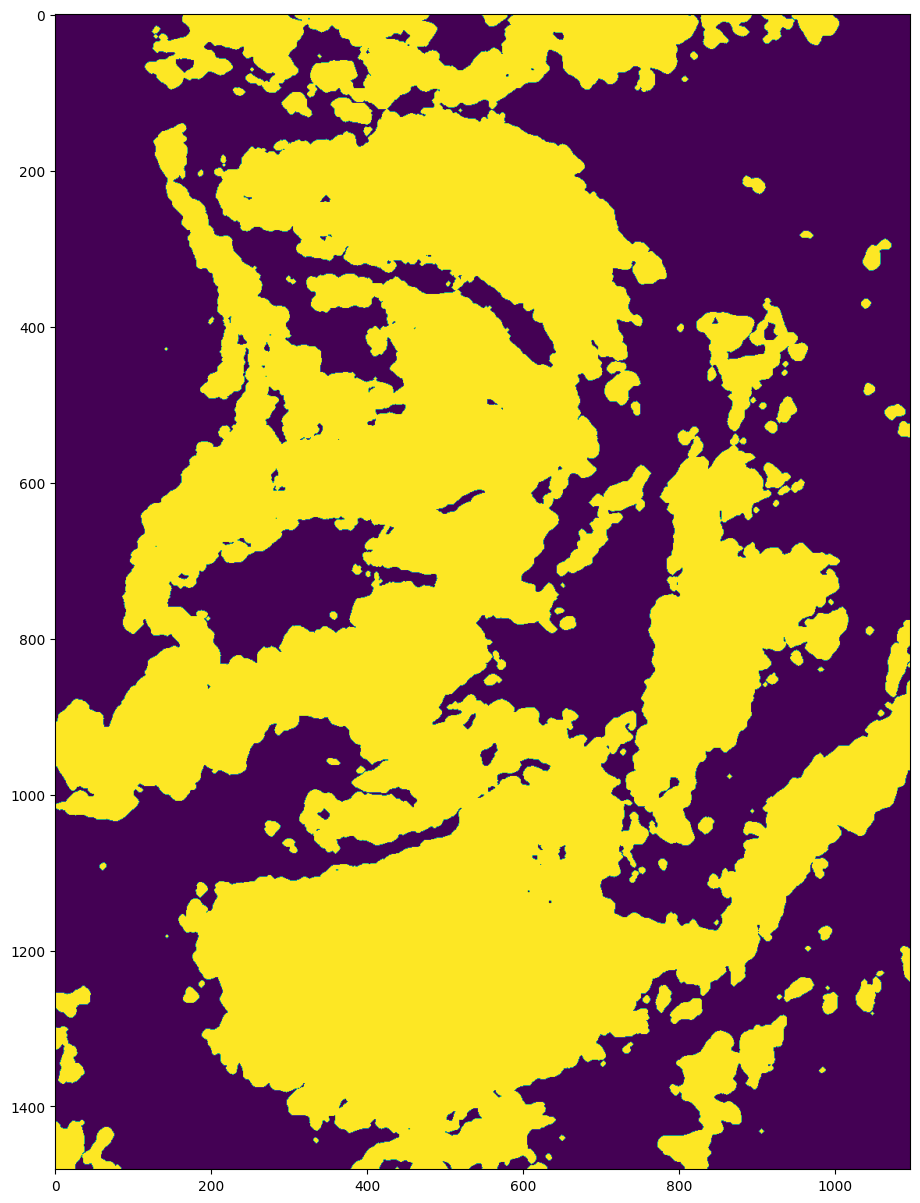

In [9]:
plot_image(cloud_mask[0])

Let's plot a true color image overlaid with the cloud mask:

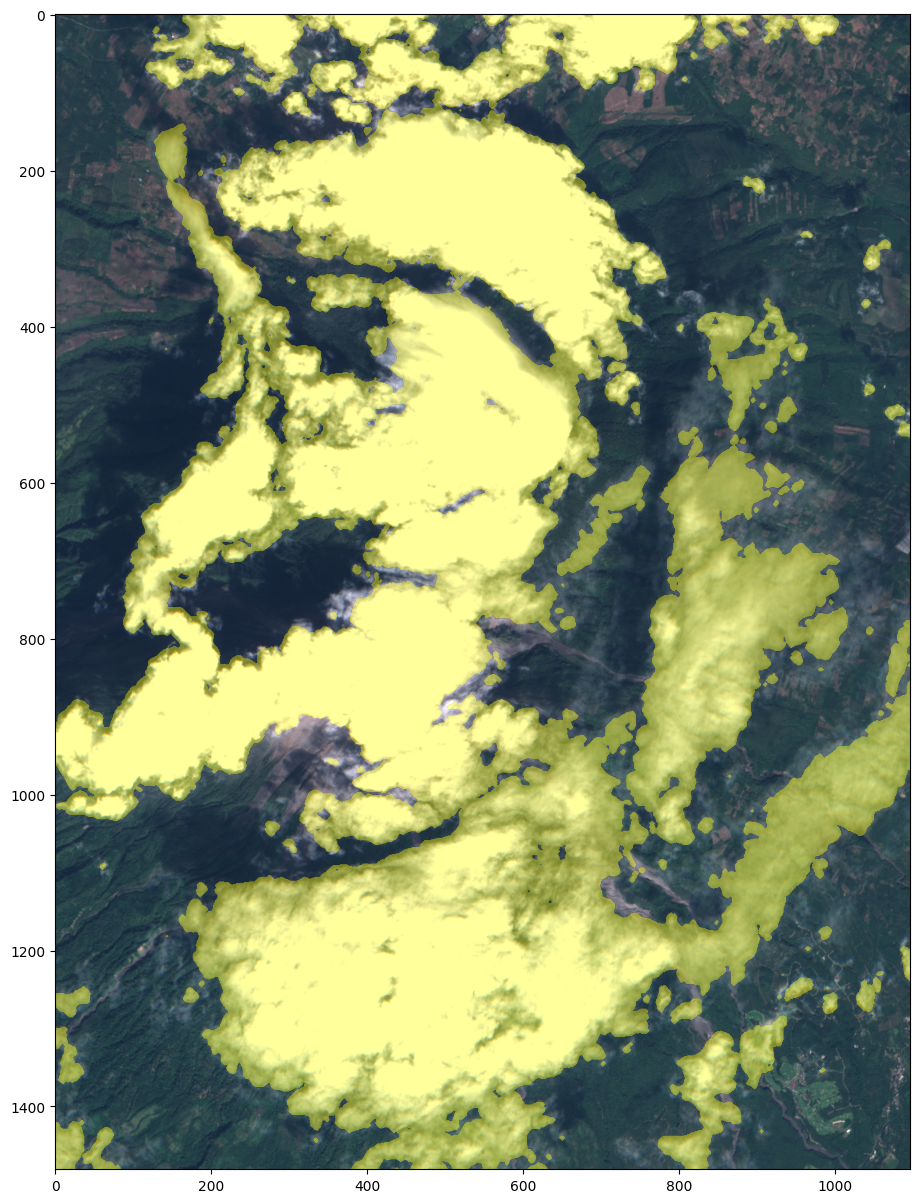

In [10]:
true_color_image = bands[..., [3, 2, 1]]

plot_image(image=true_color_image, mask=cloud_mask[0], factor=3.5)

Besides that we also have pseudo-probability scores telling us how likely it is that certain pixel is cloudy:

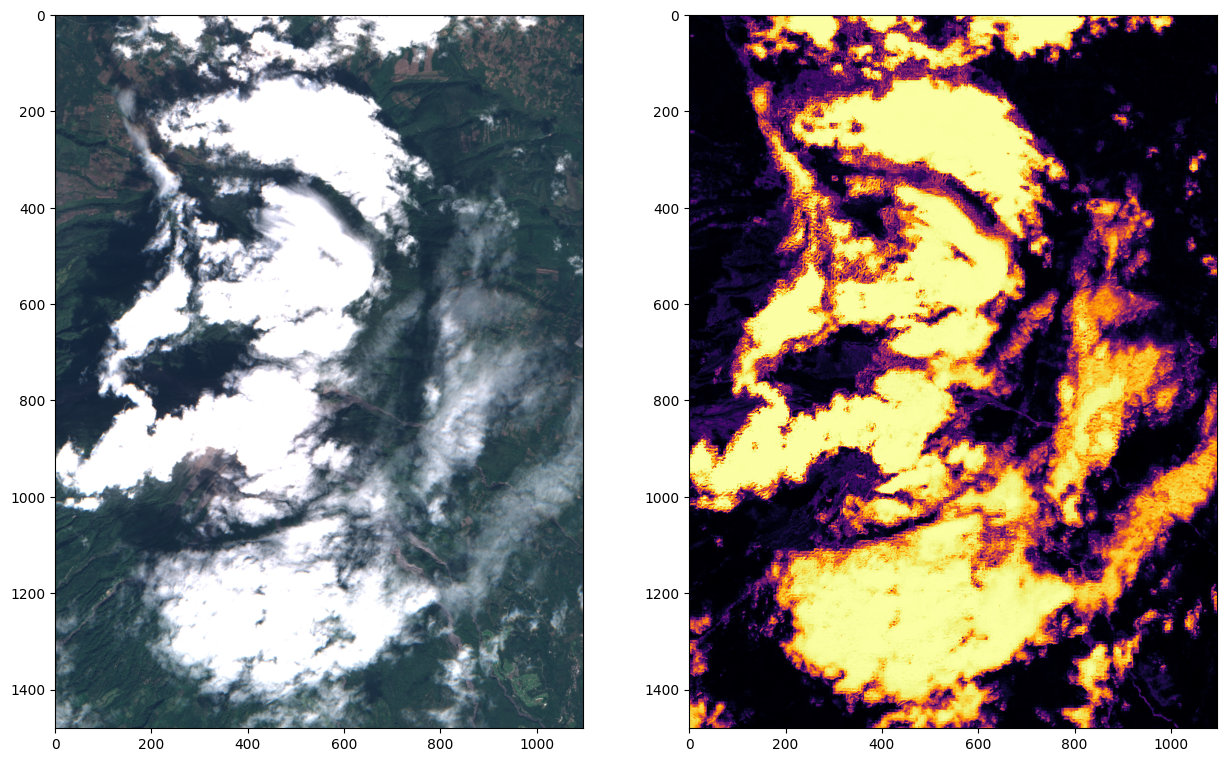

In [11]:
plot_probabilities(true_color_image, cloud_prob[0], factor=3.5)

## Advance use of s2cloudless

Second example will show how to use:

1. `get_timestamps` to obtain multiple timestamps in given time interval
2. parameter `threshold` in `get_mask_from_prob` to obtain wanted results 

`get_timestamps` is an interface to [Sentinel Hub Catalog API](https://docs.sentinel-hub.com/api/latest/api/catalog/) to obtain information when data is available. Those are the following timestamps:

In [12]:
timestamps = get_timestamps(bbox=bbox, time_interval=(dt.datetime(2017, 12, 1), dt.datetime(2017, 12, 7)))

timestamps

[datetime.datetime(2017, 12, 1, 16, 38, 51, tzinfo=tzutc()),
 datetime.datetime(2017, 12, 6, 16, 32, 21, tzinfo=tzutc())]

Download of data for all `timestamps`:

In [13]:
bands, masks = download_bands_and_valid_data_mask(bbox=bbox, size=bbox_to_dimensions(bbox, 10), timestamps=timestamps)

In [14]:
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=1, dilation_size=1, all_bands=True)

probability_maps = cloud_detector.get_cloud_probability_maps(bands)
mask_prob = cloud_detector.get_mask_from_prob(probability_maps)

Let's extract RGB bands:

In [15]:
true_color_images = bands[..., [3, 2, 1]]

Let's plot cloud masks together with images:

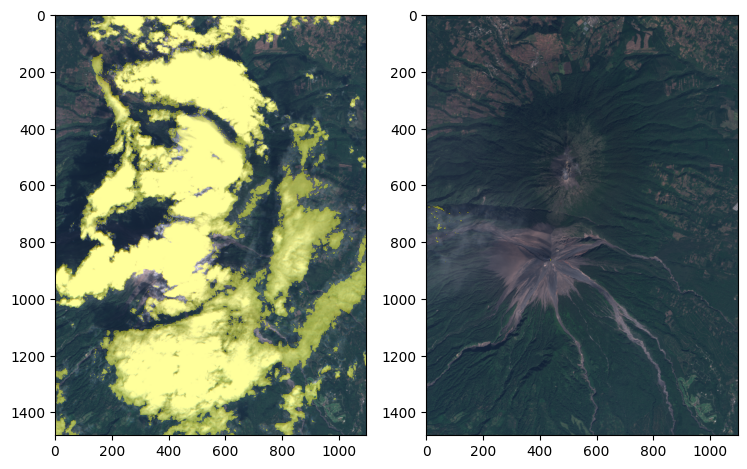

In [16]:
fig = plt.figure(figsize=(15, 10))
n_cols = 4
n_rows = int(np.ceil(len(true_color_images) / n_cols))

for idx, (image, mask) in enumerate(zip(true_color_images, mask_prob)):
    ax = fig.add_subplot(n_rows, n_cols, idx + 1)
    plot_image(image, mask, ax=ax, factor=3.5)

plt.tight_layout()

If the default probability threshold of `0.4` doesn't suit us we can override it to compute new binary cloud masks with a different threshold:

In [17]:
mask_prob_2 = cloud_detector.get_mask_from_prob(probability_maps, threshold=0.2)

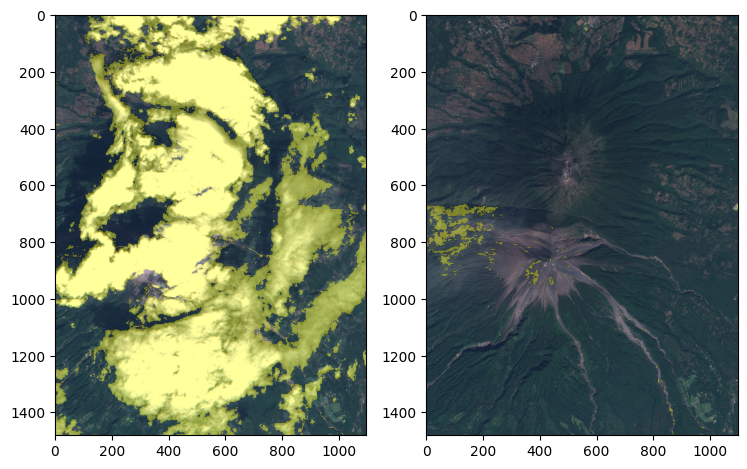

In [18]:
fig = plt.figure(figsize=(15, 10))
n_cols = 4
n_rows = int(np.ceil(len(true_color_images) / n_cols))

for idx, (image, mask) in enumerate(zip(true_color_images, mask_prob_2)):
    ax = fig.add_subplot(n_rows, n_cols, idx + 1)
    plot_image(image, mask, ax=ax, factor=3.5)

plt.tight_layout()